In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt

# Continuous Time Epidemic Models 

In [9]:
def sir1(beta, gamma, S0, I0, R0):
    # initial values
    S = S0
    I = I0
    R = R0
    N = S0 + I0 + R0
    t = 0

    # keep track of time epidemic state
    accum = [(t, S, I, R)]

    # simulate until epidemic ends
    while True:

        # 1. calculate rates
        si_rate = beta * S * I / (S + I + R)
        ir_rate = gamma * I
        total_rate = si_rate + ir_rate

        # exit condition
        if total_rate == 0.0:
            break

        # 2. sample next event (event is a transition from S -> I or I -> R)
        tstar = np.random.exponential(1 / total_rate)

        t += tstar

        # 3. sample type of even (here we choose between S -> I or I -> R - exclusive
        if np.random.uniform() < si_rate / total_rate:
            S -= 1
            I += 1
            R = R  # add 0
        else:
            S = S  # add 0
            I -= 1
            R += 1

        # 4. Keep track of progress
        accum.append((t, S, I, R))

    # format for output
    results = np.array(accum)
    return dict(t=results[:, 0],
                S=results[:, 1],
                I=results[:, 2],
                R=results[:, 3])

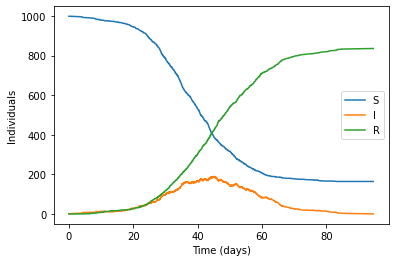

In [10]:
# simulate a simple epidemic
epi = sir1(beta=0.3, gamma=0.14, S0=999, I0=1, R0=0)

plt.plot(epi['t'], epi['S'], label='S')
plt.plot(epi['t'], epi['I'], label='I')
plt.plot(epi['t'], epi['R'], label='R')
plt.legend()
plt.xlabel("Time (days)")
_ = plt.ylabel("Individuals")

In [5]:
# the above code can be made more efficient with some vectorization of the steps


def cts_time_epidemic(initial_state, incidence_matrix, spread_rates):
    '''
    initial_state: 
        3-tuple of (S,I,R) 

    incidence_matrix:
        Represents transitions between states of the model 

    spread_rates:
        2-tuple of (beta, gamma) 
    '''
    # initial
    current_state = initial_state.copy()
    t = 0

    # keep track of time epidemic state
    state_accum = [initial_state]
    t_accum = [t]

    # simulate until epidemic ends
    while True:

        # 1. calculate rates
        si_rate = current_state[0]*current_state[1] * \
            spread_rates[0]/np.sum(initial_state)
        ir_rate = spread_rates[1] * current_state[1]
        total_rate = si_rate + ir_rate

        # exit condition
        if total_rate == 0.0:
            break

        # 2. sample next event (event is a transition from S -> I or I -> R)
        tstar = np.random.exponential(1 / total_rate)
        t += tstar
        # 3. sample type of even (here we choose between S -> I or I -> R - exclusive
        next_event = np.random.multinomial(n=1,
                                           pvals=(si_rate / total_rate,
                                                  ir_rate / total_rate))

        # 4. Keep track of progress
        current_state += incidence_matrix.dot(next_event)

        # Append result to accumulation buffer
        state_accum.append(current_state.copy())
        t_accum.append(t)

    # Reformat results and return
    state_result = np.stack(state_accum, axis=0)
    t_result = np.stack(t_accum, axis=0)
    return dict(t=t_result, state=state_result)

In [6]:
# Model specification
incidence_matrix = np.array([[-1, 0],
                             [1, -1],
                             [0, 1]])

initial_state = [999, 1, 0]

epi2 = cts_time_epidemic(initial_state=initial_state,
                         incidence_matrix=incidence_matrix,
                         spread_rates=(0.4, 0.14))

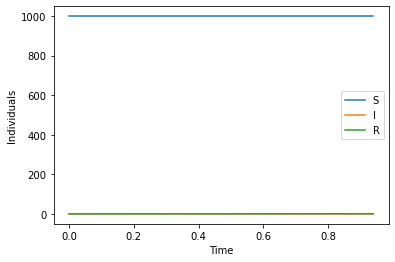

In [7]:
plt.plot(epi2['t'], epi2['state'][:, 0], label='S')
plt.plot(epi2['t'], epi2['state'][:, 1], label='I')
plt.plot(epi2['t'], epi2['state'][:, 2], label='R')
plt.legend()
plt.xlabel("Time")
_ = plt.ylabel("Individuals")

In [8]:
%timeit sir1(beta=0.3, gamma=0.14, S0=999, I0=1, R0=0)

4.44 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit cts_time_epidemic(initial_state=initial_state, incidence_matrix=incidence_matrix, spread_rates=(0.3, 0.14))

34.3 ms ± 5.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# playing with different transition rates

def transition_rates(beta, gamma, phi):
    def fn(state):
        si_rate = beta * np.power(state[1], phi) * state[0] / np.sum(state)
        ir_rate = gamma * state[1]

        return np.stack([si_rate, ir_rate], axis=0)

    return fn

In [11]:
def cts_time_epidemic2(transition_rate_fn, initial_state, incidence_matrix):
    current_state = initial_state.copy()
    t = 0

    state_accum = [initial_state]
    t_accum = [t]

    while True:

        # Calculate rates
        rates = transition_rate_fn(current_state)
        total_rate = np.sum(rates)

        if total_rate == 0.0:  # Break if epidemic stops
            break

        # Draw time to next event, update t
        tstar = np.random.exponential(1.0/total_rate)
        t += tstar

        # Draw event one hot vector
        next_event = np.random.multinomial(n=1,
                                           pvals=rates/total_rate)

        # Propagate state
        current_state += incidence_matrix.dot(next_event)

        # Append result to accumulation buffer
        state_accum.append(current_state.copy())
        t_accum.append(t)

    # Reformat results and return
    state_result = np.stack(state_accum, axis=0)
    t_result = np.stack(t_accum, axis=0)
    return dict(t=t_result, state=state_result)

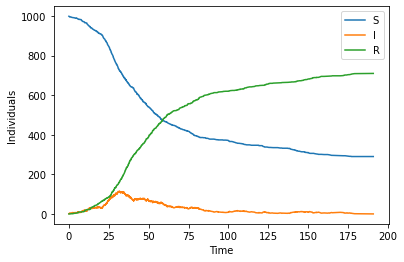

In [12]:
# reuse incidence matrix from before 
epi3 = cts_time_epidemic2(transition_rate_fn=transition_rates(0.5, 0.14, 0.8),
                           initial_state=initial_state,
                           incidence_matrix=incidence_matrix)

plt.plot(epi3['t'], epi3['state'][:, 0], label='S')
plt.plot(epi3['t'], epi3['state'][:, 1], label='I')
plt.plot(epi3['t'], epi3['state'][:, 2], label='R')
plt.legend()
plt.xlabel("Time")
_ = plt.ylabel("Individuals")

# Discrete Time Epidemic Models 

# Playing with Einsum


In [13]:
# define some arrays
a = np.array([[0, 1, 2],
              [3, 4, 5],
              [6, 7, 8]])
b = np.array([[1, 0, 0, 0],
              [1, 1, 0, 0],
              [1, 1, 1, 0]])

In [14]:
[f"Dim(a): {a.shape}", f"Dim(b): {b.shape}"]

['Dim(a): (3, 3)', 'Dim(b): (3, 4)']

In [15]:
# transpose of a matrix 
np.einsum('ji', b)

array([[1, 1, 1],
       [0, 1, 1],
       [0, 0, 1],
       [0, 0, 0]])

In [16]:
# diagonal of a matrix - only works on square matrix! 
np.einsum('ii-> i',a) 

array([0, 4, 8])

In [17]:
# this is a row sum! Since j isn't shown, the function sums over that dimension 
np.einsum('ij -> i', a)
# np.einsum('ji -> j', a) transposed column sum = row sum 

array([ 3, 12, 21])

In [18]:
# column sum 
np.einsum('ij -> j', a)

array([ 9, 12, 15])

In [19]:
# trace 
np.einsum('ii', a)

12

In [20]:
# sum of all entries
# having no arrow just means show the matrix, here we map to the sum along the i and j dim
np.einsum('ij -> ', a)

36

In [21]:
# matrix mult 
np.einsum('ij,jk -> ik', a, b)

array([[ 3,  3,  2,  0],
       [12,  9,  5,  0],
       [21, 15,  8,  0]])

In [22]:
np.einsum('ji,jk -> ik', b, a) # transpose b, then mult my a 

array([[ 9, 12, 15],
       [ 9, 11, 13],
       [ 6,  7,  8],
       [ 0,  0,  0]])

In [23]:
# dot product
np.einsum('ij,jk', a, b)

array([[ 3,  3,  2,  0],
       [12,  9,  5,  0],
       [21, 15,  8,  0]])

In [24]:
# inner product 
np.einsum('ij,kj->ik', a, a)

array([[  5,  14,  23],
       [ 14,  50,  86],
       [ 23,  86, 149]])

In [25]:
# multiply b.col by EACH row of a - output is a 3D array now 
np.einsum('ij,jk -> ijk', a,b)

array([[[0, 0, 0, 0],
        [1, 1, 0, 0],
        [2, 2, 2, 0]],

       [[3, 0, 0, 0],
        [4, 4, 0, 0],
        [5, 5, 5, 0]],

       [[6, 0, 0, 0],
        [7, 7, 0, 0],
        [8, 8, 8, 0]]])

In [26]:
np.einsum('ij,jk -> ijk', a,b)

array([[[0, 0, 0, 0],
        [1, 1, 0, 0],
        [2, 2, 2, 0]],

       [[3, 0, 0, 0],
        [4, 4, 0, 0],
        [5, 5, 5, 0]],

       [[6, 0, 0, 0],
        [7, 7, 0, 0],
        [8, 8, 8, 0]]])

# From simulation to inference 

In [35]:
simulated_epidemic = pd.DataFrame(epi3['state'], columns=['S', 'I', 'R'])

In [36]:
simulated_epidemic.head()

,S,I,R
0,999,1,0
1,998,2,0
2,997,3,0
3,996,4,0
4,995,5,0
